# Part 1, Model 1B: Basic Glaucoma Detection using K-Nearest Neighbors (KNN), XgBoost and a linear C-Support Vector Classification (SVM classifier) on the fundus, optic cup and optic disk images of the eye. The features were extracted using the MobileNetV3 model.

In [1]:
%pip install scikit-learn
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.preprocessing import StandardScaler  # Fix import statement
# to prevent unnecessary warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import tensorflow as tf

#import useful module for keras library
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2

# get modules from sklearn library
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

#import libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

2024-01-27 19:37:41.850851: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-27 19:37:41.850920: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-27 19:37:41.880023: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-27 19:37:41.974913: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-27 19:37:43.393794: W tensorflow/compiler/tf2

In [3]:
#check keras version
import tensorflow
print(tensorflow.__version__)

2.15.0


In [4]:
#check keras version
import keras
print(keras.__version__)

2.15.0


In [5]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

data = pd.read_csv('metadata - standardized.csv')

In [6]:
data.columns

Index(['names', 'types', 'type_expanded', 'isColor', 'original_name',
       'patient_id', 'fundus', 'fundus_od_seg', 'fundus_oc_seg', 'bv_seg',
       'artery_seg', 'vein_seg', 'oct', 'oct_oc_seg', 'oct_od_seg', 'sex',
       'gender', 'age', 'eye', 'sbp', 'dbp', 'hr', 'iop', 'vcdr',
       'Unnamed: 24', 'notchI_present', 'notchS_present', 'notchN_present',
       'notchT_present', 'expert1_grade', 'expert2_grade', 'expert3_grade',
       'expert4_grade', 'expert5_grade', 'cdr_avg', 'cdr_expert1',
       'cdr_expert2', 'cdr_expert3', 'cdr_expert4', 'refractive_dioptre_1',
       'refractive_dioptre_2', 'refractive_astigmatism',
       'phakic_or_pseudophakic', 'iop_perkins', 'iop_pneumatic', 'pachymetry',
       'axial_length', 'visual_field_mean_defect'],
      dtype='object')

In [7]:
data.head()

,names,types,type_expanded,isColor,original_name,patient_id,fundus,fundus_od_seg,fundus_oc_seg,bv_seg,...,cdr_expert4,refractive_dioptre_1,refractive_dioptre_2,refractive_astigmatism,phakic_or_pseudophakic,iop_perkins,iop_pneumatic,pachymetry,axial_length,visual_field_mean_defect
0,OIA-ODIR-TEST-OFFLINE-1,0,NaN,1,1029_right.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-1.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,OIA-ODIR-TEST-OFFLINE-2,0,NaN,1,1049_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-2.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,OIA-ODIR-TEST-OFFLINE-4,0,NaN,1,1128_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-4.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,OIA-ODIR-TEST-OFFLINE-5,0,NaN,1,1179_right.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-5.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,OIA-ODIR-TEST-OFFLINE-6,0,NaN,1,1180_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-6.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
data[data['fundus_oc_seg'].notnull() & data['fundus_od_seg'].notnull()].info()

print(data['fundus_oc_seg'].notnull().value_counts())

data[data['fundus_oc_seg'].notnull()]

<class 'pandas.core.frame.DataFrame'>
Index: 3102 entries, 4546 to 12048
Data columns (total 48 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   names                     3102 non-null   object 
 1   types                     3102 non-null   int64  
 2   type_expanded             1848 non-null   object 
 3   isColor                   3102 non-null   int64  
 4   original_name             3102 non-null   object 
 5   patient_id                488 non-null    object 
 6   fundus                    3102 non-null   object 
 7   fundus_od_seg             3102 non-null   object 
 8   fundus_oc_seg             3102 non-null   object 
 9   bv_seg                    0 non-null      object 
 10  artery_seg                0 non-null      object 
 11  vein_seg                  0 non-null      object 
 12  oct                       44 non-null     object 
 13  oct_oc_seg                44 non-null     object 
 14  oct_od_se

,names,types,type_expanded,isColor,original_name,patient_id,fundus,fundus_od_seg,fundus_oc_seg,bv_seg,...,cdr_expert4,refractive_dioptre_1,refractive_dioptre_2,refractive_astigmatism,phakic_or_pseudophakic,iop_perkins,iop_pneumatic,pachymetry,axial_length,visual_field_mean_defect
4546,ORIGA-1,0,NaN,1,001.jpg,NaN,/full-fundus/ORIGA-1.png,/optic-disc/ORIGA-1.png,/optic-cup/ORIGA-1.png,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4547,ORIGA-2,0,NaN,1,002.jpg,NaN,/full-fundus/ORIGA-2.png,/optic-disc/ORIGA-2.png,/optic-cup/ORIGA-2.png,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4548,ORIGA-3,0,NaN,1,003.jpg,NaN,/full-fundus/ORIGA-3.png,/optic-disc/ORIGA-3.png,/optic-cup/ORIGA-3.png,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4549,ORIGA-4,0,NaN,1,004.jpg,NaN,/full-fundus/ORIGA-4.png,/optic-disc/ORIGA-4.png,/optic-cup/ORIGA-4.png,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4550,ORIGA-5,0,NaN,1,005.jpg,NaN,/full-fundus/ORIGA-5.png,/optic-disc/ORIGA-5.png,/optic-cup/ORIGA-5.png,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12044,PAPILA-484,0,Healthy,1,289,PAPILA-289,/full-fundus/PAPILA-484.png,/optic-disc/PAPILA-484.png,/optic-cup/PAPILA-484.png,NaN,...,NaN,0.75,-1.5,93,1,10,,531,22.31,
12045,PAPILA-485,0,Healthy,1,290,PAPILA-290,/full-fundus/PAPILA-485.png,/optic-disc/PAPILA-485.png,/optic-cup/PAPILA-485.png,NaN,...,NaN,0.25,-0.25,160,1,19,,573,22.01,
12046,PAPILA-486,0,Healthy,1,291,PAPILA-291,/full-fundus/PAPILA-486.png,/optic-disc/PAPILA-486.png,/optic-cup/PAPILA-486.png,NaN,...,NaN,1.5,-1.25,76,0,14,,443,23.51,
12047,PAPILA-487,0,Healthy,1,292,PAPILA-292,/full-fundus/PAPILA-487.png,/optic-disc/PAPILA-487.png,/optic-cup/PAPILA-487.png,NaN,...,NaN,1.25,-0.75,79,0,9,,479,23.84,


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12449 entries, 0 to 12448
Data columns (total 48 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   names                     12449 non-null  object 
 1   types                     12449 non-null  int64  
 2   type_expanded             6577 non-null   object 
 3   isColor                   12449 non-null  int64  
 4   original_name             12449 non-null  object 
 5   patient_id                488 non-null    object 
 6   fundus                    12449 non-null  object 
 7   fundus_od_seg             3103 non-null   object 
 8   fundus_oc_seg             3103 non-null   object 
 9   bv_seg                    462 non-null    object 
 10  artery_seg                22 non-null     object 
 11  vein_seg                  22 non-null     object 
 12  oct                       79 non-null     object 
 13  oct_oc_seg                45 non-null     object 
 14  oct_od

In [10]:
data['fundus_oc_seg'][12044]

'/optic-cup/PAPILA-484.png'

In [11]:
data['fundus_od_seg'][12044]

'/optic-disc/PAPILA-484.png'

In [12]:
data['artery_seg'].value_counts()

artery_seg
/vessel-artery/LES-AV-1.png     1
/vessel-artery/LES-AV-2.png     1
/vessel-artery/LES-AV-21.png    1
/vessel-artery/LES-AV-20.png    1
/vessel-artery/LES-AV-19.png    1
/vessel-artery/LES-AV-18.png    1
/vessel-artery/LES-AV-17.png    1
/vessel-artery/LES-AV-16.png    1
/vessel-artery/LES-AV-15.png    1
/vessel-artery/LES-AV-14.png    1
/vessel-artery/LES-AV-13.png    1
/vessel-artery/LES-AV-12.png    1
/vessel-artery/LES-AV-11.png    1
/vessel-artery/LES-AV-10.png    1
/vessel-artery/LES-AV-9.png     1
/vessel-artery/LES-AV-8.png     1
/vessel-artery/LES-AV-7.png     1
/vessel-artery/LES-AV-6.png     1
/vessel-artery/LES-AV-5.png     1
/vessel-artery/LES-AV-4.png     1
/vessel-artery/LES-AV-3.png     1
/vessel-artery/LES-AV-22.png    1
Name: count, dtype: int64

In [13]:
data['vein_seg'].value_counts()

vein_seg
/vessel-vein/LES-AV-1.png     1
/vessel-vein/LES-AV-2.png     1
/vessel-vein/LES-AV-21.png    1
/vessel-vein/LES-AV-20.png    1
/vessel-vein/LES-AV-19.png    1
/vessel-vein/LES-AV-18.png    1
/vessel-vein/LES-AV-17.png    1
/vessel-vein/LES-AV-16.png    1
/vessel-vein/LES-AV-15.png    1
/vessel-vein/LES-AV-14.png    1
/vessel-vein/LES-AV-13.png    1
/vessel-vein/LES-AV-12.png    1
/vessel-vein/LES-AV-11.png    1
/vessel-vein/LES-AV-10.png    1
/vessel-vein/LES-AV-9.png     1
/vessel-vein/LES-AV-8.png     1
/vessel-vein/LES-AV-7.png     1
/vessel-vein/LES-AV-6.png     1
/vessel-vein/LES-AV-5.png     1
/vessel-vein/LES-AV-4.png     1
/vessel-vein/LES-AV-3.png     1
/vessel-vein/LES-AV-22.png    1
Name: count, dtype: int64

In [14]:
data['oct'].value_counts()

oct
/spectral-oct/CRFO-v4-1.png     1
/spectral-oct/CRFO-v4-51.png    1
/spectral-oct/CRFO-v4-58.png    1
/spectral-oct/CRFO-v4-57.png    1
/spectral-oct/CRFO-v4-56.png    1
                               ..
/spectral-oct/CRFO-v4-26.png    1
/spectral-oct/CRFO-v4-25.png    1
/spectral-oct/CRFO-v4-24.png    1
/spectral-oct/CRFO-v4-23.png    1
/spectral-oct/CRFO-v4-79.png    1
Name: count, Length: 79, dtype: int64

In [15]:
print(data['fundus'][12044])
print(data['fundus_oc_seg'][12044])
print(data['fundus_od_seg'][12044])

/full-fundus/PAPILA-484.png
/optic-cup/PAPILA-484.png
/optic-disc/PAPILA-484.png


full-fundus/full-fundus/PAPILA-484.png


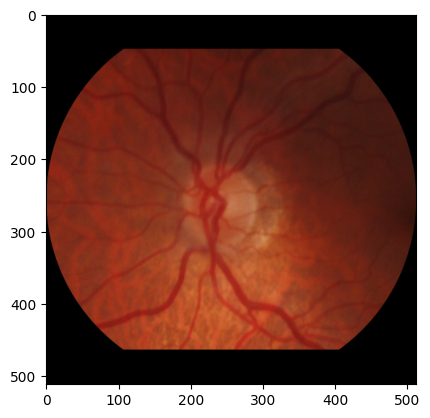

optic-cup/optic-cup/PAPILA-484.png


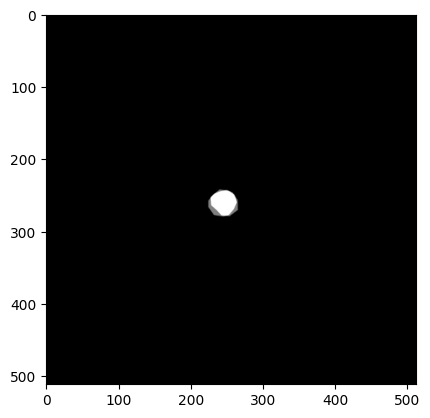

In [16]:
import os
import random

def viewFundus(image_path):

    image_path = 'full-fundus' + image_path

    print(image_path)

    # Load the image
    image = cv2.imread(image_path)

    # Convert the image from BGR to RGB color space
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.imshow(image_rgb)
    plt.axis('on')  # Hide the axis to only show the image
    plt.show()

def viewOpticCup(image_path):

    image_path = 'optic-cup' + image_path

    print(image_path)

    # Load the image
    image = cv2.imread(image_path)

    # Convert the image from BGR to RGB color space
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.imshow(image_rgb)
    plt.axis('on')  # Hide the axis to only show the image
    plt.show()


viewFundus(data['fundus'][12044])
viewOpticCup(data['fundus_oc_seg'][12044])

In [17]:
#removing the patients with no fundus classification and with fundus classification -1 instead of 0,1
fundus_subset = data[(data['fundus'].notnull()) & (data['types'] != -1)]

fundus_subset = fundus_subset[['types', 'fundus', 'names']]

fundus_subset['combined'] = fundus_subset['names'] + '.png'

fundus_subset['fundus'] = fundus_subset['fundus'].astype(str)

fundus_subset['types'] = fundus_subset['types'].astype(str)

fundus_subset.info()


<class 'pandas.core.frame.DataFrame'>
Index: 12316 entries, 0 to 12448
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   types     12316 non-null  object
 1   fundus    12316 non-null  object
 2   names     12316 non-null  object
 3   combined  12316 non-null  object
dtypes: object(4)
memory usage: 481.1+ KB


In [18]:
fundus_subset_dataOnly = data[(data['fundus'].notnull()) & (data['types'] != -1)]

fundus_subset_dataOnly

,names,types,type_expanded,isColor,original_name,patient_id,fundus,fundus_od_seg,fundus_oc_seg,bv_seg,...,cdr_expert4,refractive_dioptre_1,refractive_dioptre_2,refractive_astigmatism,phakic_or_pseudophakic,iop_perkins,iop_pneumatic,pachymetry,axial_length,visual_field_mean_defect
0,OIA-ODIR-TEST-OFFLINE-1,0,NaN,1,1029_right.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-1.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,OIA-ODIR-TEST-OFFLINE-2,0,NaN,1,1049_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-2.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,OIA-ODIR-TEST-OFFLINE-4,0,NaN,1,1128_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-4.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,OIA-ODIR-TEST-OFFLINE-5,0,NaN,1,1179_right.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-5.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,OIA-ODIR-TEST-OFFLINE-6,0,NaN,1,1180_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-6.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12444,FIVES-396,0,Healthy,1,Test_196,NaN,/full-fundus/FIVES-396.png,NaN,NaN,/blood-vessel/FIVES-396.png,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12445,FIVES-397,0,Healthy,1,Test_197,NaN,/full-fundus/FIVES-397.png,NaN,NaN,/blood-vessel/FIVES-397.png,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12446,FIVES-398,0,Healthy,1,Test_198,NaN,/full-fundus/FIVES-398.png,NaN,NaN,/blood-vessel/FIVES-398.png,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12447,FIVES-399,0,Healthy,1,Test_199,NaN,/full-fundus/FIVES-399.png,NaN,NaN,/blood-vessel/FIVES-399.png,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
fundus_subset_dataOnly.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12316 entries, 0 to 12448
Data columns (total 48 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   names                     12316 non-null  object 
 1   types                     12316 non-null  int64  
 2   type_expanded             6509 non-null   object 
 3   isColor                   12316 non-null  int64  
 4   original_name             12316 non-null  object 
 5   patient_id                420 non-null    object 
 6   fundus                    12316 non-null  object 
 7   fundus_od_seg             3035 non-null   object 
 8   fundus_oc_seg             3035 non-null   object 
 9   bv_seg                    462 non-null    object 
 10  artery_seg                22 non-null     object 
 11  vein_seg                  22 non-null     object 
 12  oct                       79 non-null     object 
 13  oct_oc_seg                45 non-null     object 
 14  oct_od_seg 

In [20]:
fundus_subset_dataOnly['sex'].value_counts()

sex
M    2475
F    1989
Name: count, dtype: int64

In [21]:
fundus_subset_dataOnly['eye'].value_counts()

eye
OS    2863
OD    2750
Name: count, dtype: int64

In [22]:
non_image_features_wrong = ['fundus', 'fundus_oc_seg', 'fundus_od_seg', 'artery_seg', 'bv_seg', 'vein_seg', 'oct', 'names', 'gender', 'iop']

non_image_features_final = ['sex', 'gender', 'age', 'eye', 'sbp', 'dbp', 'hr', 'iop']

non_image_features = fundus_subset_dataOnly[['gender', 'age', 'sbp', 'dbp', 'hr', 'iop']].to_numpy()


In [23]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
non_image_features_scaled = scaler.fit_transform(non_image_features)

In [24]:
fundus_subset.head()

,types,fundus,names,combined
0,0,/full-fundus/OIA-ODIR-TEST-OFFLINE-1.png,OIA-ODIR-TEST-OFFLINE-1,OIA-ODIR-TEST-OFFLINE-1.png
1,0,/full-fundus/OIA-ODIR-TEST-OFFLINE-2.png,OIA-ODIR-TEST-OFFLINE-2,OIA-ODIR-TEST-OFFLINE-2.png
2,0,/full-fundus/OIA-ODIR-TEST-OFFLINE-4.png,OIA-ODIR-TEST-OFFLINE-4,OIA-ODIR-TEST-OFFLINE-4.png
3,0,/full-fundus/OIA-ODIR-TEST-OFFLINE-5.png,OIA-ODIR-TEST-OFFLINE-5,OIA-ODIR-TEST-OFFLINE-5.png
4,0,/full-fundus/OIA-ODIR-TEST-OFFLINE-6.png,OIA-ODIR-TEST-OFFLINE-6,OIA-ODIR-TEST-OFFLINE-6.png


In [25]:
fundus_subset['types'].value_counts()

types
0    7549
1    4767
Name: count, dtype: int64

In [26]:
fundus_subset = data[(data['fundus'].notnull()) & (data['fundus'] != -1)]
fundus_subset = fundus_subset[['types', 'fundus', 'names']]

fundus_subset['combined'] = fundus_subset['names'] + '.png'

fundus_subset['fundus'] = fundus_subset['fundus'].astype(str)

fundus_subset['types'] = fundus_subset['types'].astype(str)

fundus_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12449 entries, 0 to 12448
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   types     12449 non-null  object
 1   fundus    12449 non-null  object
 2   names     12449 non-null  object
 3   combined  12449 non-null  object
dtypes: object(4)
memory usage: 389.2+ KB


In [27]:
# glaucoma fundus images
glaucomaCount = len(fundus_subset[(fundus_subset['types'] == '1')])
print("this is the glaucoma count", glaucomaCount)

# healthy fundus images
healthyCount = len(fundus_subset[(fundus_subset['types'] == '0')])
print("this is the healthy eyes count", healthyCount)

print('\nTotal fundus images to  be used: ', glaucomaCount + healthyCount)

# randomize data
fundus_subset_random = fundus_subset.sample(frac=1, random_state=1)

# create df for each class based on randomized data
healthy_subset = fundus_subset_random[fundus_subset_random['types'] == '0']
glaucoma_subset = fundus_subset_random[fundus_subset_random['types'] == '1']

testSize = 500
valSize = 500

# get train items
healthy_train = healthy_subset.head(healthyCount - testSize)
glaucoma_train = glaucoma_subset.head(glaucomaCount - testSize)
train = healthy_train._append(glaucoma_train)

# get val items
healthy_val = healthy_subset.tail(valSize)
glaucoma_val = glaucoma_subset.tail(valSize)
val = healthy_val._append(glaucoma_val)

# get test items
healthy_test = healthy_subset.tail(testSize)
glaucoma_test = glaucoma_subset.tail(testSize)
test = healthy_test._append(glaucoma_test)

this is the glaucoma count 4767
this is the healthy eyes count 7549

Total fundus images to  be used:  12316


In [47]:
print("Train Size: ", len(train))
print("Val Size: ", len(val))
print("Test Size: ", len(test))

Train Size:  11316
Val Size:  1000
Test Size:  1000


In [29]:
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-01-27 19:37:45.604513: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-27 19:37:46.018897: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-27 19:37:46.019315: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [30]:
import tensorflow
print(tensorflow.__version__)

2.15.0


In [31]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v3 import preprocess_input


# Set target size and batch size for data generator
target = 224
batchSize = 8

# Set the class mode to 'binary' for training data generator
classes = 'binary'

with tf.device('/GPU:0'):


    # Create the training data generator
    trainDataGen = ImageDataGenerator(preprocessing_function=preprocess_input)
    trainGen = trainDataGen.flow_from_dataframe(dataframe=train, 
                                                directory='full-fundus/full-fundus', 
                                                class_mode = classes,
                                                batch_size = batchSize, 
                                                shuffle=True, 
                                                x_col="combined", 
                                                y_col="types", 
                                                validate_filenames=True, 
                                                target_size=(target, target), 
                                                color_mode='rgb')


    # Create the validation data generator
    valDataGen = ImageDataGenerator(preprocessing_function=preprocess_input)
    valGen = valDataGen.flow_from_dataframe(dataframe=val,
                                            directory='full-fundus/full-fundus',   
                                            batch_size = batchSize, 
                                            class_mode = classes,
                                            shuffle=False, 
                                            x_col="combined", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(target, target), 
                                            color_mode='rgb')


    # Create the testing data generator
    testDataGen = ImageDataGenerator(preprocessing_function=preprocess_input)
    testGen = testDataGen.flow_from_dataframe(dataframe=test,
                                            directory='full-fundus/full-fundus',   
                                            batch_size = batchSize, 
                                            class_mode = classes,
                                            shuffle=False, 
                                            x_col="combined", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(target, target), 
                                            color_mode='rgb')

2024-01-27 19:37:46.046450: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-27 19:37:46.046871: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-27 19:37:46.047152: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-27 19:37:46.258467: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-27 19:37:46.258944: I external/local_xla/xla/stream_executor

Found 11316 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.


In [32]:
with tf.device('/GPU:0'):

    classes = 'sparse'

    healthy_subsetDataGen = ImageDataGenerator(preprocessing_function=preprocess_input)
    healthy_subset_Gen = trainDataGen.flow_from_dataframe(dataframe=healthy_subset, 
                                                directory='full-fundus/full-fundus', 
                                                class_mode = classes,
                                                batch_size = batchSize, 
                                                shuffle=True, 
                                                x_col="combined", 
                                                y_col="types", 
                                                validate_filenames=True, 
                                                target_size=(target, target), 
                                                color_mode='rgb')


    glaucoma_subsetDataGen = ImageDataGenerator(preprocessing_function=preprocess_input)
    glaucoma_subset_Gen = glaucoma_subsetDataGen.flow_from_dataframe(dataframe=glaucoma_subset, 
                                                directory='full-fundus/full-fundus', 
                                                class_mode = classes,
                                                batch_size = batchSize, 
                                                shuffle=True, 
                                                x_col="combined", 
                                                y_col="types", 
                                                validate_filenames=True, 
                                                target_size=(target, target), 
                                                color_mode='rgb')

Found 7549 validated image filenames belonging to 1 classes.
Found 4767 validated image filenames belonging to 1 classes.


In [33]:
def show_images(gen):
    
    g_dict = gen.class_indices
    classes = list(g_dict.keys())
    images, labels = next(gen)

    length = len(labels)
    sample = min(length, 25)

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(4, 4, i + 1)
        image = images[i] / 255
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

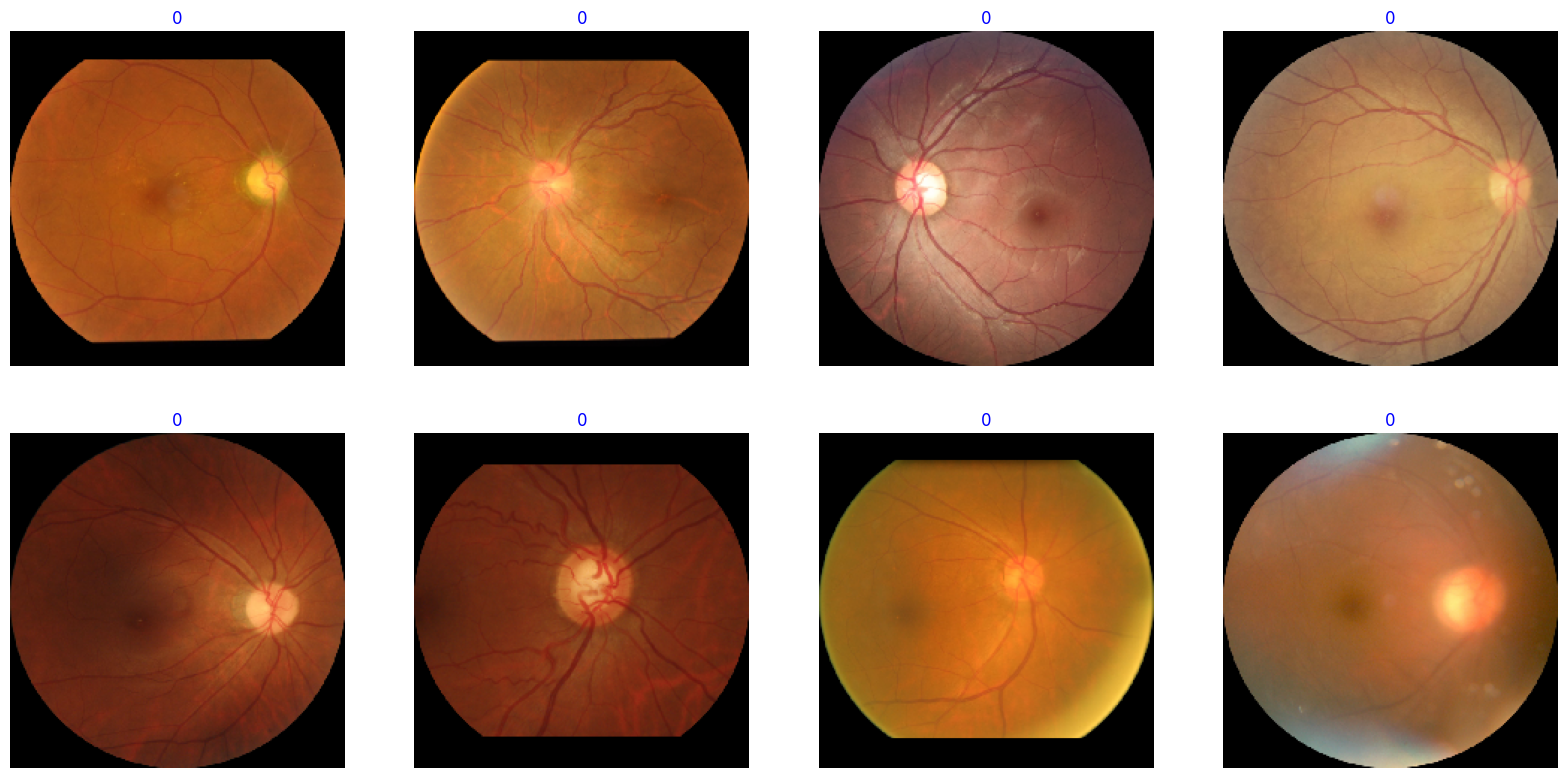

In [34]:
show_images(healthy_subset_Gen)

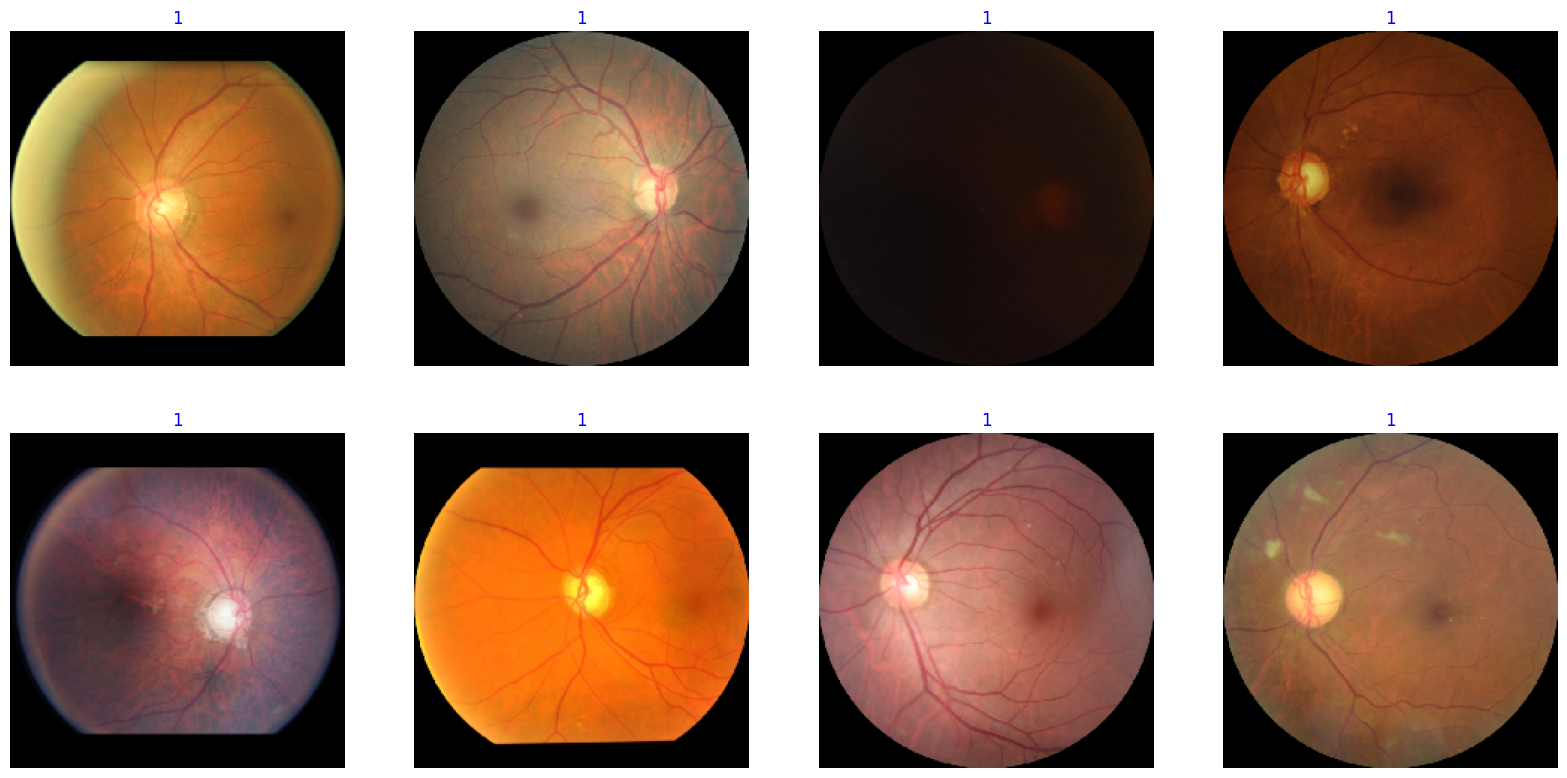

In [35]:
show_images(glaucoma_subset_Gen)

In [36]:
from keras.applications import MobileNetV3Small
from keras import Sequential

input_shape = (target, target, 3)

base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(target, target, 3))

model = Sequential([
    base_model, layers.GlobalAveragePooling2D()
])

def extract_features(generator, sample_count):
    
    features = np.zeros(shape=(sample_count, model.layers[-1].output.shape[1]))
    labels = np.zeros(shape=(sample_count))
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = model.predict(inputs_batch)
        features[i * batchSize: (i + 1) * batchSize] = features_batch
        labels[i * batchSize: (i + 1) * batchSize] = labels_batch
        i += 1
        if i * batchSize >= sample_count:
            break
    return features, labels

In [37]:
import numpy as np

with tf.device('/GPU:0'):

    train_features, train_labels = extract_features(trainGen, trainGen.samples)
    val_features, val_labels = extract_features(valGen, valGen.samples)
    test_features, test_labels = extract_features(testGen, testGen.samples)

2024-01-27 19:38:48.848086: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-27 19:38:49.289501: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 3s 3s/step


2024-01-27 19:38:50.504573: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 0s 32ms/step


In [38]:
print("Number of features in training set:", train_features.shape[1])
print("Number of features in validation set:", val_features.shape[1])
print("Number of features in test set:", test_features.shape[1])

Number of features in training set: 576
Number of features in validation set: 576
Number of features in test set: 576


In [39]:
# Combine training features
train_combined_features = np.hstack((train_features, non_image_features_scaled[:len(train_labels)]))

# Combine validation features
val_combined_features = np.hstack((val_features, non_image_features_scaled[len(train_labels):len(train_labels)+len(val_labels)]))

# Combine test features
test_combined_features = np.hstack((test_features, non_image_features_scaled[-len(test_labels):]))

In [40]:
print("Number of features in training set:", train_combined_features.shape[1])
print("Number of features in validation set:", val_combined_features.shape[1])
print("Number of features in test set:", test_combined_features.shape[1])

Number of features in training set: 582
Number of features in validation set: 582
Number of features in test set: 582


In [45]:
print(len(train_labels))
print(len(val_labels))
print(len(test_labels))

11316
1000
1000


In [46]:
print(len(train_combined_features))
print(len(val_combined_features))
print(len(test_combined_features))

11316
1000
1000


In [1]:
from sklearn.ensemble import HistGradientBoostingClassifier

with tf.device('/GPU:0'):

    # Create and train the the model
    hgb_model = HistGradientBoostingClassifier()
    hgb_model.fit(train_combined_features, train_labels)

NameError: name 'tf' is not defined

In [42]:
# Validate the SVM
val_accuracy = hgb_model.score(val_combined_features, val_labels)
print('Validation accuracy:', val_accuracy)

# Test the SVM
test_accuracy = hgb_model.score(test_combined_features, test_labels)
print('Test accuracy:', test_accuracy)

Validation accuracy: 0.809
Test accuracy: 0.809


In [43]:
from sklearn.metrics import confusion_matrix, classification_report

test_predictions = hgb_model.predict(test_combined_features)

conf_matrix = confusion_matrix(test_labels, test_predictions)
class_report = classification_report(test_labels, test_predictions)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Print the classification report
print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[456  44]
 [147 353]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.76      0.91      0.83       500
         1.0       0.89      0.71      0.79       500

    accuracy                           0.81      1000
   macro avg       0.82      0.81      0.81      1000
weighted avg       0.82      0.81      0.81      1000



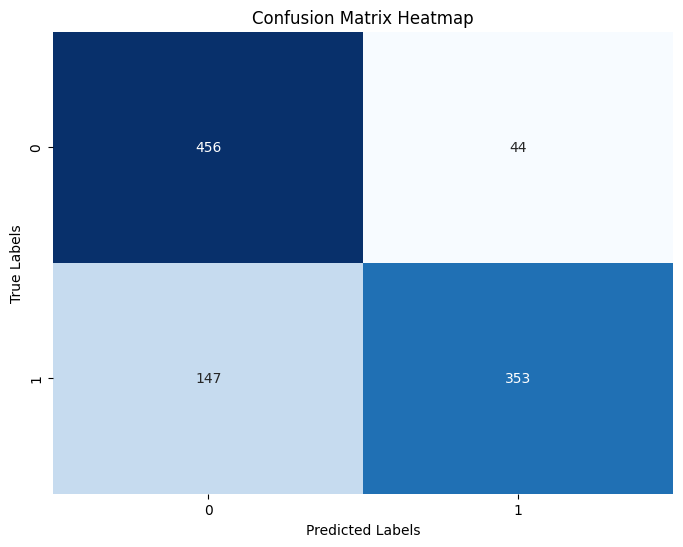

In [44]:
# Plot the confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()